# Notebook for minimal experiments and setup checks

## Training Workflow: Joint Optimization with Feedback

**Input:** Audio Chunks + Text/Speech Targets  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Chunked Audio Preprocessing**  
&nbsp;&nbsp;&nbsp;&nbsp;2s chunks, 0.5s overlap to simulate streaming  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Shared Encoder** (SeamlessM4T / Wav2Vec2)  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Acoustic Features**  
&nbsp;&nbsp;&nbsp;&nbsp;├────────────┬──────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Context Buffer**  
(S2T Path)      (S2S Path)       (Stores recent chunks)  
&nbsp;&nbsp;&nbsp;&nbsp;↓          ↓  
Text Output     Speech Units  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|        **[Neural Vocoder]**  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|       Synthesized Audio  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────┬───────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      ↓  

### Feedback Mechanism 1 — Semantic Consistency Check
- Run ASR on synthesized audio  
- Compare with text output  
- Compute similarity loss

### Feedback Mechanism 2 — Confidence Estimation
- Extract prediction scores  
- Estimate model uncertainty  

### Combined Loss Function

$$
\text{Total Loss} = L_{\text{text}} + L_{\text{speech}} + \lambda_1 L_{\text{consistency}} + \lambda_2 L_{\text{confidence}}
$$


### Backpropagation
Update all components jointly
  (Encoder, Decoders, Vocoder, Feedback modules)


## Inference Mode: Streaming with Adaptive Feedback

**Live Microphone** or **Streaming Audio File**  
&nbsp;&nbsp;&nbsp;&nbsp;↓ (continuous stream)  
**Audio Buffer Manager**  
&nbsp;&nbsp;&nbsp;&nbsp;Accumulates audio in overlapping chunks  
&nbsp;&nbsp;&nbsp;&nbsp;Chunk: 2.0s, Hop: 0.5s  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Every 0.5s, new chunk available  
**Chunk Queue** ← maintains last 3–4 chunks for context  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Process immediately (Similar to Wait-K)

**Shared Encoder**  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Features extracted   
&nbsp;&nbsp;&nbsp;&nbsp;├────────────────────┬─────────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Confidence Estimator**  
(S2T Path)      (S2S Path)       (Estimates reliability)  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    ↓     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            ↓  
Text (partial)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Speech Units  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Confidence Score  
&nbsp;&nbsp;&nbsp;&nbsp;|                |  
&nbsp;&nbsp;&nbsp;&nbsp;|                ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Vocoder**  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Audio Output  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────────────────┬───────────────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  

### Adaptive Decision Gate
- **High Confidence (> 0.90):**  
  Emit immediately
  Play audio + display text   

- **Medium Confidence (0.75–0.90):**  
  Wait for 1 more chunk  
  Re-process with more context

- **Low Confidence (< 0.75):**  
  Buffer 2–3 more chunks  
  Re-process with extended context  


### Feedback Verification *(optional for high-quality mode)*
- Run ASR on output audio  
- Check semantic match with text  
- Flag if mismatch detected  

### Output Emission
- Play synthesized speech  
- Display text translation  
- Log confidence + similarity metrics  

### Boundary Detection
- Silence detected → Reset context buffer  
- Punctuation in text → Segment boundary  
- Confidence drop → Potential speaker change  

Loop back to **Audio Buffer Manager**  
*(Next chunk ready every 0.5 s)*


# Install dependencies

In [28]:
!pip install -U openai-whisper

In [29]:
!pip install git+https://github.com/huggingface/transformers.git sentencepiece

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-6ivsoq_n
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-6ivsoq_n
  Resolved https://github.com/huggingface/transformers.git to commit e8a6eb3304033fdd9346fe3b3293309fe50de238
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [30]:
!pip install -q transformers>=4.35.0 datasets soundfile librosa torch torchaudio accelerate sentencepiece jiwer matplotlib scikit-learn scipy

# Code

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [32]:
# Load dataset
import os
import tarfile
input_path_src = '/content/drive/My Drive/cvss_c_cy_en_v1.0.tar.gz'
input_path_tgt = '/content/drive/My Drive/cv-corpus-22.0-2025-06-20.gz'
extract_directory_src = '/content/welsh_dataset'
extract_directory_tgt = '/content/eng_dataset'
os.makedirs(extract_directory_src, exist_ok=True)
os.makedirs(extract_directory_tgt, exist_ok=True)

with tarfile.open(input_path_src, 'r:gz') as tar:
    tar.extractall(extract_directory_src)

with tarfile.open(input_path_tgt, 'r:gz') as tar:
    tar.extractall(extract_directory_tgt)

print('Extracted files successfully')

Extracted files successfully


### EDA on Dataset

In [33]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import glob
import warnings
warnings.filterwarnings('ignore')


In [34]:
# Structure of dataset
audio_path_tgt = None

# Source audio
print('Source dataset structure :')
for root, dirs, files in os.walk(extract_directory_src):
    print(root, "===", len(files), 'files')

# Target audio
print('\nTarget dataset structure :')
for root, dirs, files in os.walk(extract_directory_tgt):
    print(root, "===", len(files), 'files')
    if os.path.basename(root) == 'cy':
      audio_path_tgt = root

Source dataset structure :
/content/welsh_dataset === 3 files
/content/welsh_dataset/dev === 688 files
/content/welsh_dataset/train === 1241 files
/content/welsh_dataset/test === 690 files

Target dataset structure :
/content/eng_dataset === 0 files
/content/eng_dataset/cv-corpus-22.0-2025-06-20 === 0 files
/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy === 10 files
/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/clips === 115915 files


In [35]:
# Total audio files
audio_files_src = glob.glob(os.path.join(extract_directory_src, '**/*.wav'), recursive = True)
audio_files_tgt = glob.glob(os.path.join(extract_directory_tgt, '**/*.mp3'), recursive = True)
print(f'{len(audio_files_src)} English audio found')
print(f'{len(audio_files_tgt)} Welsh audio found')

2619 English audio found
115915 Welsh audio found


In [36]:
# Metadata from audio files
metadata_src, metadata_tgt = [], []

for audio in audio_files_src[:100]:
  y, sr = librosa.load(audio, sr = None)
  duration = librosa.get_duration(y=y, sr=sr)
  metadata_src.append({'path': audio, 'duration': duration, 'sr' : sr})
source = pd.DataFrame(metadata_src)

for audio in audio_files_tgt[:100]:
  y, sr = librosa.load(audio, sr = None)
  duration = librosa.get_duration(y=y, sr=sr)
  metadata_tgt.append({'path': audio, 'duration': duration, 'sr' : sr})
target = pd.DataFrame(metadata_tgt)

In [37]:
display(source.head())
display(target.sample(5))

,path,duration,sr
0,/content/welsh_dataset/dev/common_voice_cy_190...,5.3125,24000
1,/content/welsh_dataset/dev/common_voice_cy_192...,3.7375,24000
2,/content/welsh_dataset/dev/common_voice_cy_197...,2.8875,24000
3,/content/welsh_dataset/dev/common_voice_cy_177...,1.1500,24000
4,/content/welsh_dataset/dev/common_voice_cy_190...,1.9375,24000


,path,duration,sr
86,/content/eng_dataset/cv-corpus-22.0-2025-06-20...,6.120,32000
71,/content/eng_dataset/cv-corpus-22.0-2025-06-20...,3.744,48000
66,/content/eng_dataset/cv-corpus-22.0-2025-06-20...,4.944,48000
15,/content/eng_dataset/cv-corpus-22.0-2025-06-20...,3.816,48000
41,/content/eng_dataset/cv-corpus-22.0-2025-06-20...,4.068,32000


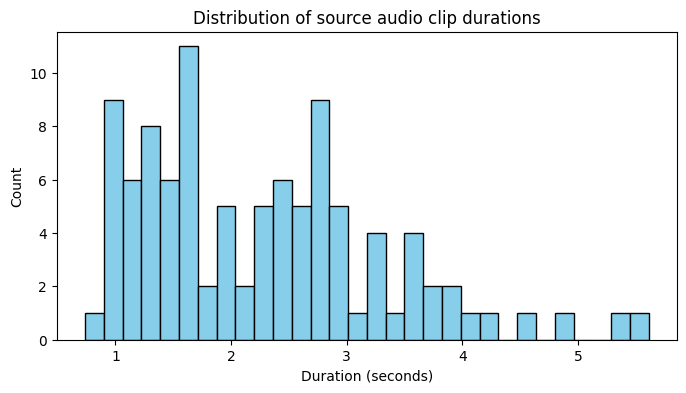

count    100.000000
mean       2.280625
std        1.054210
min        0.737500
25%        1.409375
50%        2.187500
75%        2.853125
max        5.612500
Name: duration, dtype: float64


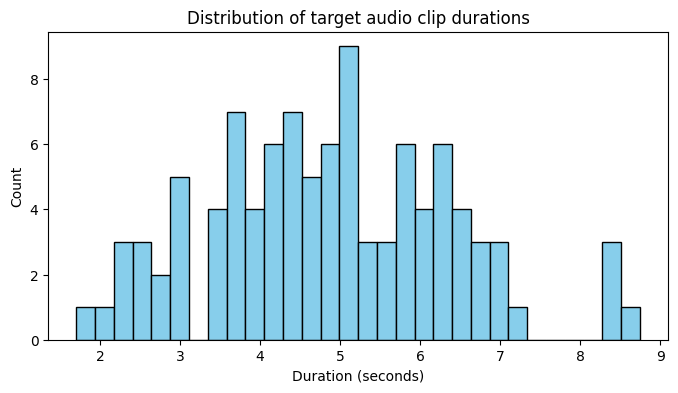

count    100.000000
mean       4.869808
std        1.514315
min        1.704000
25%        3.798000
50%        4.806000
75%        5.928000
max        8.748000
Name: duration, dtype: float64


In [38]:
# Duration distribution
plt.figure(figsize=(8, 4))
plt.hist(source['duration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of source audio clip durations")
plt.show()
print(source['duration'].describe())

plt.figure(figsize=(8, 4))
plt.hist(target['duration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of target audio clip durations")
plt.show()
print(target['duration'].describe())

In [39]:
# Transcripts analysis
text_files_src = glob.glob(os.path.join(extract_directory_src, '**/*.tsv'), recursive=True)
text_files_tgt = glob.glob(os.path.join(extract_directory_tgt, '**/*.tsv'), recursive=True)
print(f'{len(text_files_src)} source transcript files found')
print(f'{len(text_files_tgt)} target transcript files found')

3 source transcript files found
10 target transcript files found


In [40]:
texts_src, texts_tgt = [], []
for file in text_files_src:
  tsv_df = pd.read_csv(file, sep='\t', header = None)
  texts_src.append(tsv_df)
df_text_src = pd.concat(texts_src, ignore_index=True)

for file in text_files_tgt:
  tsv_df = pd.read_csv(file, sep = '\t')
  texts_tgt.append(tsv_df)
df_text_tgt = pd.concat(texts_tgt, ignore_index=True)

In [41]:
display(df_text_src.head())
display(df_text_tgt.head())

,0,1
0,common_voice_cy_17299824.mp3,what's the price of that watch
1,common_voice_cy_17315118.mp3,duwynt mornings some deep some powder shows en...
2,common_voice_cy_17315119.mp3,where do you work
3,common_voice_cy_17315120.mp3,he was a sixth form pupil and part of a pilgri...
4,common_voice_cy_17315555.mp3,do you provide lunch


,sentence_id,sentence,sentence_domain,source,locale,reason,client_id,path,up_votes,down_votes,age,gender,accents,variant,segment,is_used,clips_count,clip,duration[ms]
0,2928e3fd9f5ac35fc2abdc94662377ab227d706c0a8271...,beth wyt tin meddwl am bwyta te heno,NaN,helo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45c22614bc444da913d2797c3ef8905fd83bdc336e957a...,Sut dwi'n syllafu 'Cymru',NaN,Cymraeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5d137a5cb845a92b594e1e3c7ee9b6a40b3988784c8748...,Es I am dro ddoe,NaN,Cymraeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,733f63df7c6e59719ea3613751388612cb44c96fb5e03d...,Mae y pysgod yn nofio lawr y môr,NaN,Cymraeg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78f427c105d76a5fbfc5cd4ecb38fef70960a226fdb88c...,dwin gyfoethog,NaN,cyfoeth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_text_tgt['sentence'].fillna('', inplace=True)
df_text_tgt['word_count'] = df_text_tgt['sentence'].fillna('').apply(lambda x: len(x.split()))
df_text_tgt['char_count'] = df_text_tgt['sentence'].fillna('').apply(len)

df_text_src[1].fillna('', inplace=True)
df_text_src['word_count'] = df_text_src[1].fillna('').apply(lambda x: len(x.split()))
df_text_src['char_count'] = df_text_src[1].fillna('').apply(len)

          word_count     char_count
count  368804.000000  368804.000000
mean        6.398724      36.243238
std         5.467866      45.949959
min         0.000000       0.000000
25%         0.000000       0.000000
50%         7.000000      41.000000
75%        11.000000      60.000000
max       936.000000   15644.000000


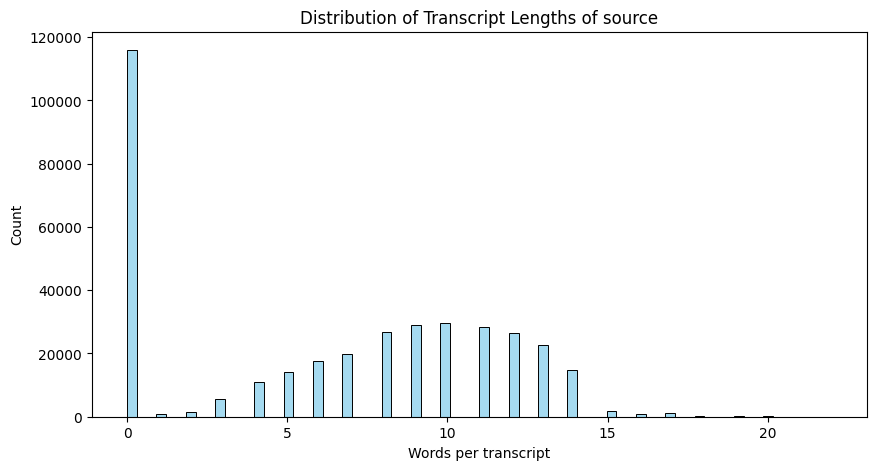

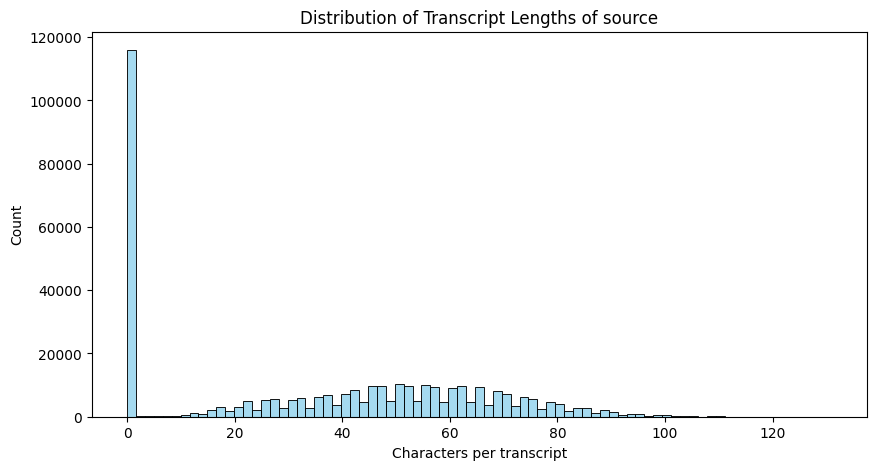

In [43]:
cols = ['sentence', 'word_count', 'char_count']
df_text_analysis = df_text_tgt[cols]
# Check distribution before removing outliers
print(df_text_analysis[['word_count', 'char_count']].describe())

# Remove outliers
Q1_wc = df_text_analysis['word_count'].quantile(0.25)
Q3_wc = df_text_analysis['word_count'].quantile(0.75)
IQR_wc = Q3_wc - Q1_wc
lower_wc = Q1_wc - 1.5 * IQR_wc
upper_wc = Q3_wc + 1.5 * IQR_wc

Q1_cc = df_text_analysis['char_count'].quantile(0.25)
Q3_cc = df_text_analysis['char_count'].quantile(0.75)
IQR_cc = Q3_cc - Q1_cc
lower_cc = Q1_cc - 1.5 * IQR_cc
upper_cc = Q3_cc + 1.5 * IQR_cc

# Filter out both word_count and char_count outliers
df_text_analysis = df_text_analysis[(df_text_analysis['word_count'].between(lower_wc, upper_wc)) & (df_text_analysis['char_count'].between(lower_cc, upper_cc))]

# Distribution of transcript lengthof source
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='word_count', color='skyblue', edgecolor='black')
plt.xlabel('Words per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of source')
plt.show()

# Distribution of transcript char length of source
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='char_count', color='skyblue', edgecolor='black')
plt.xlabel('Characters per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of source')
plt.show()


        word_count   char_count
count  2619.000000  2619.000000
mean      8.239786    42.498664
std       3.740709    20.006309
min       1.000000     2.000000
25%       5.000000    25.500000
50%       8.000000    43.000000
75%      11.000000    57.000000
max      24.000000   109.000000


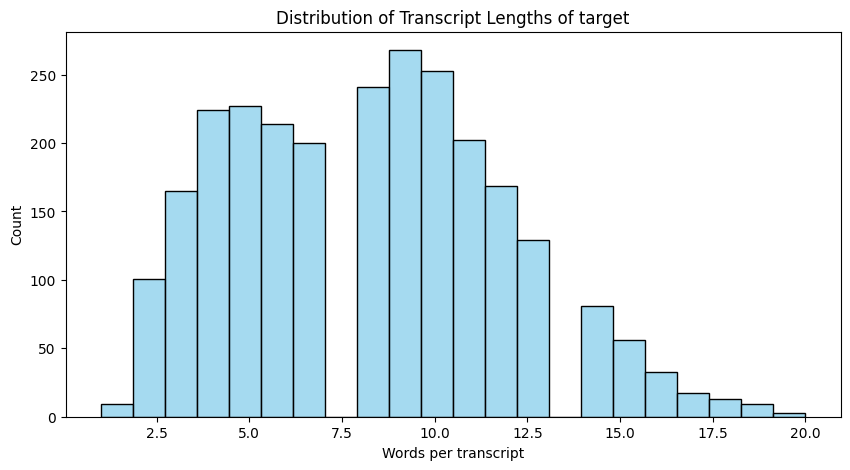

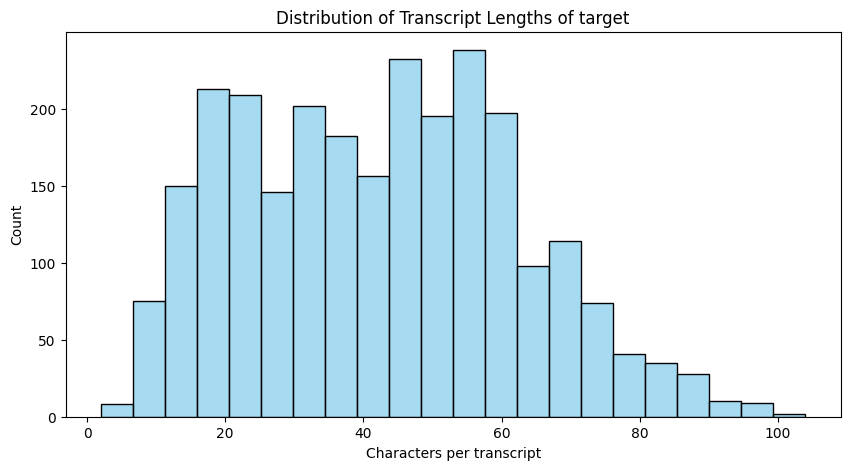

In [44]:
# Check distribution before removing outliers
print(df_text_src[['word_count', 'char_count']].describe())

# Remove outliers
Q1_wc = df_text_src['word_count'].quantile(0.25)
Q3_wc = df_text_src['word_count'].quantile(0.75)
IQR_wc = Q3_wc - Q1_wc
lower_wc = Q1_wc - 1.5 * IQR_wc
upper_wc = Q3_wc + 1.5 * IQR_wc

Q1_cc = df_text_src['char_count'].quantile(0.25)
Q3_cc = df_text_src['char_count'].quantile(0.75)
IQR_cc = Q3_cc - Q1_cc
lower_cc = Q1_cc - 1.5 * IQR_cc
upper_cc = Q3_cc + 1.5 * IQR_cc

# Filter out both word_count and char_count outliers
df_text_src = df_text_src[(df_text_src['word_count'].between(lower_wc, upper_wc)) & (df_text_src['char_count'].between(lower_cc, upper_cc))]

# Distribution of transcript length of target
plt.figure(figsize=(10, 5))
sns.histplot(df_text_src, x='word_count', color='skyblue', edgecolor='black')
plt.xlabel('Words per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of target')
plt.show()

# Distribution of transcript char length of target
plt.figure(figsize=(10, 5))
sns.histplot(df_text_src, x='char_count', color='skyblue', edgecolor='black')
plt.xlabel('Characters per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of target')
plt.show()

In [45]:
sample_audio = audio_files_src[0]
print('Sample audio : ', sample_audio)
Audio(sample_audio)

Sample audio :  /content/welsh_dataset/dev/common_voice_cy_19046493.mp3.wav


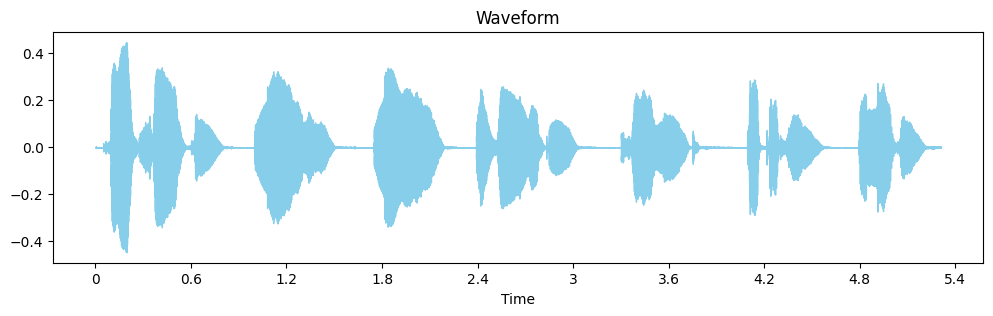

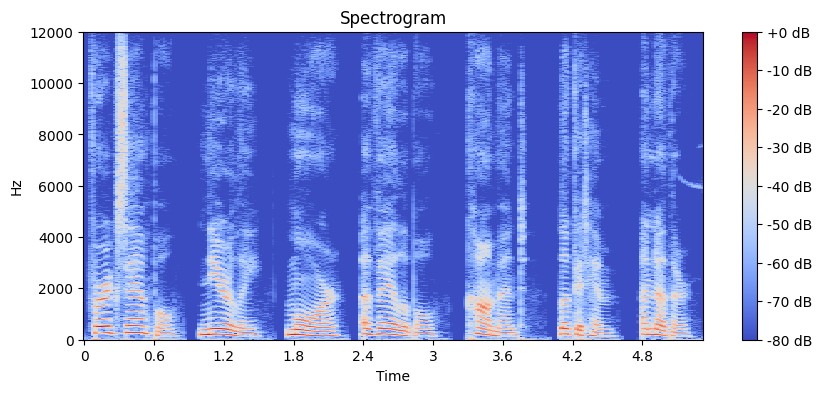

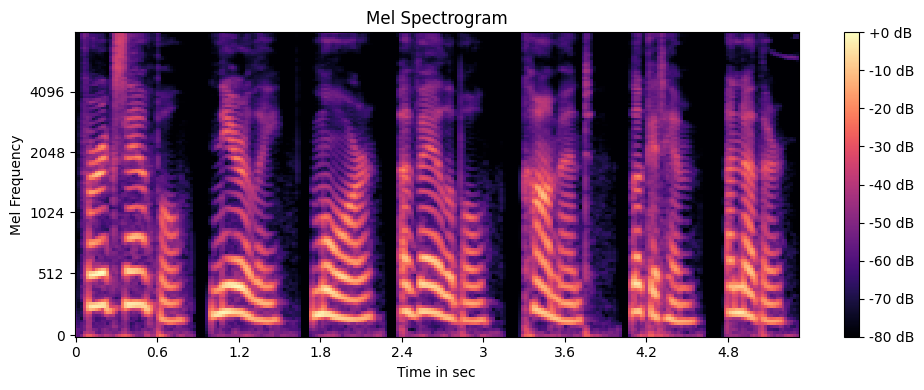

In [46]:
y, sr = librosa.load(sample_audio, sr=None)

# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, color='skyblue')
plt.title('Waveform')
plt.show()

# Spectrogram
D = np.abs(librosa.stft(y))**2
S_db = librosa.power_to_db(D, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time in sec')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

In [47]:
sample_audio = audio_files_tgt[0]
print('Sample audio : ', sample_audio)
Audio(sample_audio)

Sample audio :  /content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/clips/common_voice_cy_36481389.mp3


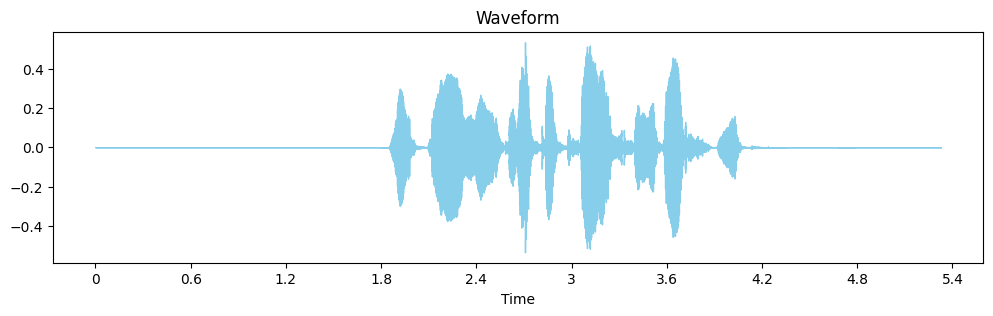

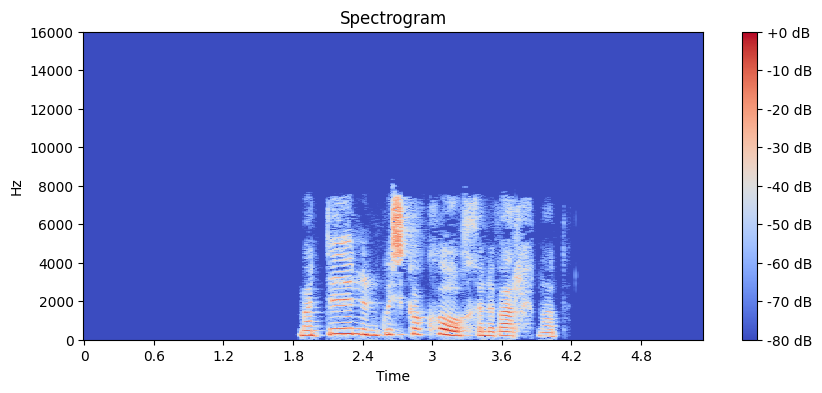

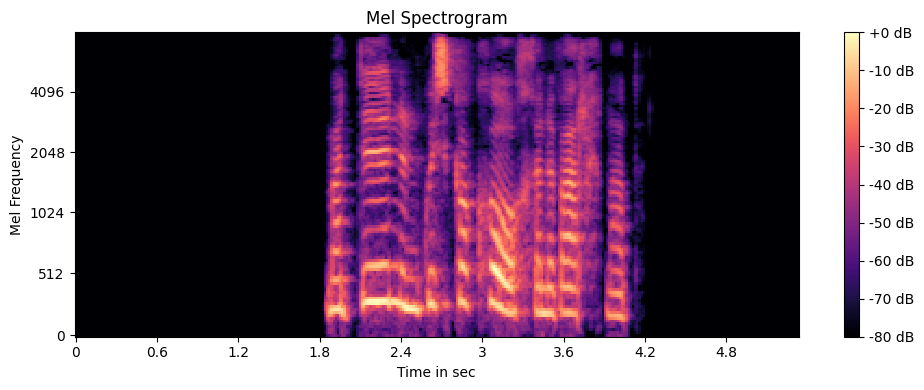

In [48]:
y, sr = librosa.load(sample_audio, sr=None)

# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, color='skyblue')
plt.title('Waveform')
plt.show()

# Spectrogram
D = np.abs(librosa.stft(y))**2
S_db = librosa.power_to_db(D, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time in sec')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

# S2S

### Import libraries

In [49]:
# Import libraries
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, util
from dataclasses import dataclass
from typing import List, Dict
from collections import deque
from tqdm import tqdm
from dataclasses import dataclass
import whisper
import time
from datetime import datetime
import json

### Prepare dataset

In [50]:
eng_train_df = pd.read_csv(os.path.join(extract_directory_src, 'train.tsv'), sep = '\t', header = None)
eng_train_df.columns = ['audio', 'sentence']
eng_train_df.head(), len(eng_train_df)

(                          audio                                      sentence
 0  common_voice_cy_17301829.mp3                            i need soap please
 1  common_voice_cy_17301830.mp3                       what time will he start
 2  common_voice_cy_17301835.mp3                             where do you live
 3  common_voice_cy_17301844.mp3  ifan huw dafydd iwan llwyd john pierce jones
 4  common_voice_cy_17301845.mp3                                 what is islam,
 1241)

In [51]:
# Check all TSV files in the Welsh audio directory
import glob

cy_tsv_files = glob.glob(os.path.join(audio_path_tgt, '*.tsv'))
print("Available Welsh TSV files:", cy_tsv_files)

# Try loading different TSV files
for tsv_file in cy_tsv_files:
    print(f"\nChecking: {tsv_file}")
    try:
        df = pd.read_csv(tsv_file, sep='\t')
        print(f"   Rows: {len(df)}")
        if 'path' in df.columns:
            sample_files = df['path'].head().tolist()
            print(f"   Sample files: {sample_files}")

            # Check if our missing files are in this TSV
            test_file = 'common_voice_cy_17301829.mp3'
            matches = df[df['path'].str.contains('17301829', na=False)]
            if len(matches) > 0:
                print(f"    FOUND {test_file} in this file!")
    except Exception as e:
        print(f"    Error: {e}")

Available Welsh TSV files: ['/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/unvalidated_sentences.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/reported.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/test.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/other.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/train.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/invalidated.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/dev.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/validated.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/validated_sentences.tsv', '/content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/clip_durations.tsv']

Checking: /content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/unvalidated_sentences.tsv
   Rows: 14

Checking: /content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/reported.tsv
   Rows: 176

Checking: /content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/test.tsv
   Rows: 5408
   Sample files: ['comm

In [52]:
def make_parallel_dataset(eng_df: pd.DataFrame, eng_audio_path: str, cy_audio_path: str) -> List:
    """
    Make a parallel dataset from English and Welsh audio + transcripts.
    """

    # 1. Set up audio paths
    eng_clips = os.path.join(eng_audio_path, 'train')
    cy_clips = os.path.join(cy_audio_path, 'clips')

    # 2. Load Welsh transcripts - USE VALIDATED.TSV (contains all files)
    cy_transcript = os.path.join(cy_audio_path, 'validated.tsv')

    if not os.path.exists(cy_transcript):
        raise FileNotFoundError(f"Welsh transcript file not found: {cy_transcript}")

    print(f" Loading Welsh transcripts from: {cy_transcript}")
    welsh_df = pd.read_csv(cy_transcript, sep='\t')

    # 3. Build metadata dictionary with normalized keys
    metadata = {}
    for _, row in welsh_df.iterrows():
        key = os.path.basename(row['path'])
        if not key.endswith('.mp3'):
            key = key + '.mp3'
        metadata[key] = row['sentence']

    print(f" Loaded {len(metadata)} Welsh audio + transcripts from validated.tsv")
    print(" Example metadata keys:", list(metadata.keys())[:5])

    # Verify that sample files exist
    sample_check = eng_df['audio'].head(5).tolist()
    print(f"\n Verifying eng_df audio files in Welsh metadata:")
    found_count = 0
    for audio_file in sample_check:
        cy_key = os.path.basename(audio_file)
        if cy_key.endswith('.mp3.wav'):
            cy_key = cy_key.replace('.mp3.wav', '.mp3')
        elif cy_key.endswith('.wav'):
            cy_key = cy_key.replace('.wav', '.mp3')

        exists = cy_key in metadata
        if exists:
            found_count += 1
        print(f"   {cy_key}: {'Found' if exists else ' Missing'}")
    print(f"   Match rate: {found_count}/{len(sample_check)}")

    # 4. Create parallel dataset
    parallel_dataset = []
    missing_transcripts = 0
    missing_audio = 0

    for i, row in eng_df.iterrows():

        # --- Welsh audio ---
        cy_audio_name = row['audio']

        # Normalize the key for lookup
        cy_key = os.path.basename(cy_audio_name)
        if cy_key.endswith('.mp3.wav'):
            cy_key = cy_key.replace('.mp3.wav', '.mp3')
        elif cy_key.endswith('.wav'):
            cy_key = cy_key.replace('.wav', '.mp3')
        elif not cy_key.endswith('.mp3'):
            cy_key = cy_key + '.mp3'

        # Try to get Welsh transcript
        cy_text = metadata.get(cy_key, '')

        if not cy_text:
            missing_transcripts += 1
            continue  # Skip if no transcript found

        # Build full path to Welsh audio
        cy_audio_path_file = os.path.join(cy_clips, cy_audio_name)
        if not os.path.exists(cy_audio_path_file):
            missing_audio += 1
            continue

        y_cy, sr_cy = librosa.load(cy_audio_path_file, sr=None)
        y_cy = librosa.resample(y_cy, orig_sr=sr_cy, target_sr=16000)

        # --- English audio ---
        eng_audio_name = f"{cy_key}.wav"
        eng_audio_path_file = os.path.join(eng_clips, eng_audio_name)
        if not os.path.exists(eng_audio_path_file):
            continue

        y_en, sr_en = librosa.load(eng_audio_path_file, sr=None)
        y_en = librosa.resample(y_en, orig_sr=sr_en, target_sr=16000)
        eng_text = row.get('sentence', '')

        # --- Add to dataset ---
        parallel_dataset.append({
            'id': i,
            'eng_audio': y_en,
            'eng_transcript': eng_text,
            'cy_audio': y_cy,
            'cy_transcript': cy_text,
            'src': eng_audio_name,
            'tgt': cy_audio_name
        })

    print(f"\nSuccessfully loaded {len(parallel_dataset)} parallel pairs")
    print(f"Skipped due to missing transcripts: {missing_transcripts}")
    print(f"Skipped due to missing audio files: {missing_audio}")

    return parallel_dataset

In [53]:

parallel_dataset = make_parallel_dataset(eng_train_df, extract_directory_src, audio_path_tgt)

# Check the first 3 entries
print("\n First 3 parallel pairs:")
for i, item in enumerate(parallel_dataset[:3]):
    print(f"\n[{i}]")
    print(f"  English: {item['eng_transcript']}")
    print(f"  Welsh: {item['cy_transcript']}")
    print(f"  Source: {item['src']}")
    print(f"  Target: {item['tgt']}")

 Loading Welsh transcripts from: /content/eng_dataset/cv-corpus-22.0-2025-06-20/cy/validated.tsv
 Loaded 90776 Welsh audio + transcripts from validated.tsv
 Example metadata keys: ['common_voice_cy_31488241.mp3', 'common_voice_cy_24495268.mp3', 'common_voice_cy_18357273.mp3', 'common_voice_cy_25169480.mp3', 'common_voice_cy_19132010.mp3']

 Verifying eng_df audio files in Welsh metadata:
   common_voice_cy_17301829.mp3: Found
   common_voice_cy_17301830.mp3: Found
   common_voice_cy_17301835.mp3: Found
   common_voice_cy_17301844.mp3: Found
   common_voice_cy_17301845.mp3: Found
   Match rate: 5/5

Successfully loaded 1241 parallel pairs
Skipped due to missing transcripts: 0
Skipped due to missing audio files: 0

 First 3 parallel pairs:

[0]
  English: i need soap please
  Welsh: Mae angen sebon arna i, os gwelwch yn dda.
  Source: common_voice_cy_17301829.mp3.wav
  Target: common_voice_cy_17301829.mp3

[1]
  English: what time will he start
  Welsh: Faint o'r gloch fydd o'n dechrau?


In [54]:
parallel_dataset[:3]

[{'id': 0,
  'eng_audio': array([ 8.3589659e-04,  1.1703324e-03,  1.1525394e-03, ...,
          5.8207661e-11, -5.8207661e-11,  1.1641532e-10], dtype=float32),
  'eng_transcript': 'i need soap please',
  'cy_audio': array([-1.2732926e-11, -4.5474735e-12,  1.4097168e-11, ...,
         -4.6382229e-07,  5.4650445e-07,  9.3370363e-07], dtype=float32),
  'cy_transcript': 'Mae angen sebon arna i, os gwelwch yn dda.',
  'src': 'common_voice_cy_17301829.mp3.wav',
  'tgt': 'common_voice_cy_17301829.mp3'},
 {'id': 1,
  'eng_audio': array([ 7.5494684e-04,  1.0414989e-03,  1.0550146e-03, ...,
          1.2098171e-06, -1.1129887e-06,  1.1659868e-06], dtype=float32),
  'eng_transcript': 'what time will he start',
  'cy_audio': array([-6.8212103e-12, -2.7284841e-12,  2.7284841e-12, ...,
         -8.0095524e-06,  5.0972621e-06, -9.4979041e-06], dtype=float32),
  'cy_transcript': "Faint o'r gloch fydd o'n dechrau?",
  'src': 'common_voice_cy_17301830.mp3.wav',
  'tgt': 'common_voice_cy_17301830.mp3'},
